In [1]:
%pylab inline
import pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import geopandas as gp
from datetime import datetime

from code.main import getSettings, data_preload
from code.misc.logger import getLogger
from code.misc import getRegScore

In [3]:
from code.iteration import iteration, iterate

In [111]:
idx = pd.IndexSlice

# LOAD DATA

In [4]:
settings = getSettings()

In [5]:
start = datetime.now()  # start of the calculations

logger = getLogger()
settings['limit'] = None
settings['logger'] = logger
result_path = datetime.now().strftime(start.strftime(settings['results']))

In [165]:
poi, buff, reg = data_preload(settings, logger)

## Check Visually

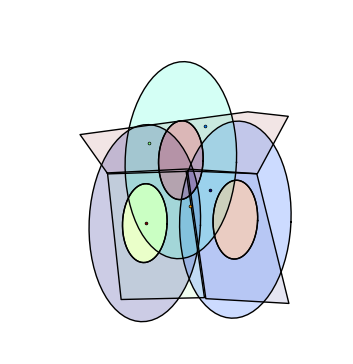

In [63]:
ax = reg.plot(alpha=.1)
buff.plot(alpha=.2, ax=ax)
poi.plot(ax=ax)

plt.axis('off');

# Check Poi Calculation

In [64]:
from code.misc import getPoiScore, adjustScore, getPOI

### Check Buffer coefficients

In [65]:
poi_test = poi.copy()
poi_test['type'] = pd.Series(['foot']*3 + ['stepless']*2)

In [66]:
result = adjustScore(poi_test, settings)

In [67]:
assert (result['score'] == pd.Series([320.0, 640.0, 80.0, 1500.0, 1000.0])).all()

## Check spatial grouping

In [96]:
x = getPOI(buff, poi, settings)

In [97]:
assert len(x)==10

In [98]:
x = adjustScore(x, settings)

In [99]:
result_score = x.groupby('office_id').agg({'score': 'sum'})
print result_score

            score
office_id        
1          2280.0
2          1520.0
3          3040.0


In [100]:
from pandas.util.testing import isiterable


In [105]:
def get_pois(pois):
    '''gets two types of pois, 
    depending of "aquisition" buffer'''
    stepless_poi = pois[pois['type']=='stepless'].groupby('office_id').agg({'pid': lambda x: list(x)}).unstack()
    foot_poi = pois[pois['type']=='foot'].groupby('office_id').agg({'pid': lambda x: list(x)}).unstack()

    pois = pd.DataFrame({'stepless_poi':stepless_poi,
                 'foot_poi': foot_poi})
    pois.index = pois.index.get_level_values(1)
    return pois

In [107]:
pois = get_pois(x)
pois

,foot_poi,stepless_poi
office_id,,
1,"[3, 5]",[1]
2,"[5, 2]",NaN
3,"[3, 5, 2, 4, 1]",NaN


## Check overal function

In [17]:
poi_score, pois = getPoiScore(buff, poi, settings)

In [18]:
poi_score

,score
office_id,
1,2080.0
2,1520.0
3,3040.0


In [19]:
pois

,pid
office_id,
1,"[3, 5, 1]"
2,"[5, 2]"
3,"[3, 5, 1, 2, 4]"


# Check region calculations

## Check spatial part

In [20]:
results = []
for n, g in buff.reset_index().groupby('office_id'):
    r = gp.overlay(g, reg, how='intersection')
    results.append(r)
    
my_result = gp.GeoDataFrame(pd.concat(results))[['type','geometry','disabled', 'reg_area','office_id']]

In [21]:
my_result.shape

(15, 5)

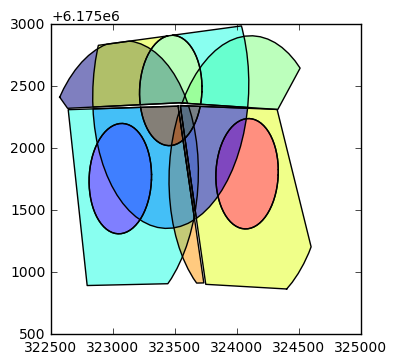

In [22]:
my_result.plot()

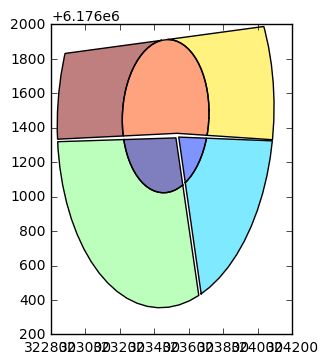

In [23]:
my_result[my_result['office_id']==3].plot()

In [24]:
my_result

,type,geometry,disabled,reg_area,office_id
0,foot,"POLYGON ((322569.6944128273 6177413.595974888,...",800,1.156767e+06,1
1,foot,"POLYGON ((323310.3556331785 6176790.093814585,...",1000,1.303664e+06,1
2,foot,"POLYGON ((323662.7476201417 6176497.762616686,...",2000,1.236994e+06,1
3,foot,"POLYGON ((323525.0569058114 6177341.294306075,...",1000,1.303664e+06,1
0,foot,"POLYGON ((323557.0034034352 6177366.168350809,...",800,1.156767e+06,2
1,foot,"POLYGON ((324400.3249126037 6175866.549602199,...",2000,1.236994e+06,2
2,foot,"POLYGON ((323532.2178882511 6177291.933233486,...",1000,1.303664e+06,2
3,foot,"POLYGON ((324332.6017424413 6176829.626446117,...",2000,1.236994e+06,2
0,foot,"POLYGON ((323222.4088805444 6177331.497032088,...",1000,1.303664e+06,3
1,foot,"POLYGON ((323579.2481288934 6177081.493049243,...",2000,1.236994e+06,3


In [25]:
my_result[my_result['office_id']==1].shape

(4, 5)

In [27]:
my_result['disabled'] * (my_result.area / my_result['reg_area'])

0     268.351435
1     269.440193
2      90.868259
3     679.812846
0     271.881359
1    1358.537272
2     137.299140
3     567.908665
0      62.940613
1      40.704721
2     462.100536
3     399.176487
4     174.966463
5     158.187374
6     143.870367
dtype: float64

## Check calculations

In [28]:
g = getRegScore(buff, reg, settings)

In [29]:
g.

,score
office_id,
1,1044
2,1866
3,1150


## Check Data update

In [121]:
buff[buff.index.get_level_values(1) != 2]

geometry id  \
type     office_id                                                         
foot     1          POLYGON ((323686.6899008526 6176731.152308405,...  0   
         3          POLYGON ((324093.4350822463 6177442.195657966,...  2   
stepless 1          POLYGON ((323309.7956804333 6176746.429837143,...  0   
         3          POLYGON ((323716.6030875866 6177457.439125905,...  2   

                   priority  
type     office_id           
foot     1             None  
         3             None  
stepless 1             None  
         3             None

In [125]:
buff.loc[idx['foot',:],'geometry']

type  office_id
foot  1            POLYGON ((323686.6899008526 6176731.152308405,...
      2            POLYGON ((324708.9411055354 6176770.773440831,...
      3            POLYGON ((324093.4350822463 6177442.195657966,...
Name: geometry, dtype: object

In [130]:
bid = 1

slctd_foot = buff.loc[idx['foot', bid], 'geometry']
slctd_step = buff.loc[idx['stepless', bid], 'geometry']
buff = buff[buff.index.get_level_values(1) != bid]

In [142]:
fs = buff.loc[idx['stepless', :], :].copy()
fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_foot)

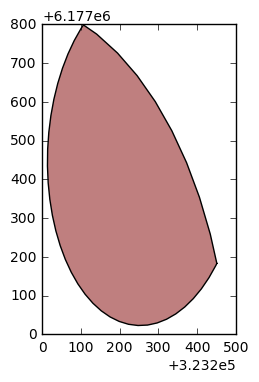

In [143]:
fs.plot()

In [157]:
def get_fc(buff, slctd_step):
        fs = buff.loc[idx['stepless', :], :].copy()
        fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_step)
        fs.index = pd.MultiIndex.from_tuples([('foot_to_step', i) for _ , i in fs.index.tolist()])
        fs = fs[~fs['geometry'].is_empty]

        return pd.concat([buff, fs])

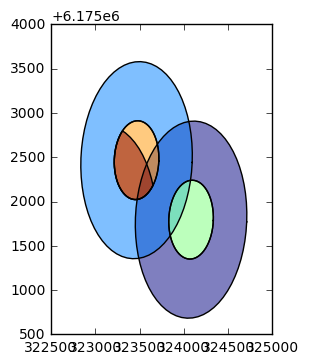

In [158]:
get_fc(buff, slctd_foot).plot()

In [198]:
def get_fc(buff, slctd_foot):
        '''adds a third type of buffer
        one where foot distance is already covered,
        but stepless is not. pois and regions here
        will add a score=difference between foot and stepless

        Args:
            buff: current buffs
            slctd_step: stepless buffer for selected office
        Returns:
            buff: buff with new buffers adder
        '''
        fs = buff.loc[idx['stepless', :], :].copy()
        
        fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_foot)
        fs.index = pd.MultiIndex.from_tuples([('foot_to_step', i) for _, i in fs.index.tolist()])
        fs = fs[~fs['geometry'].is_empty]

        return pd.concat([buff, fs]).sort_index()


def update_buff(buff, bid):
        '''update buff by removing
        and substracting
        buffers for chosen office

        Args:
            buff: buffers
            bid(int): id of chosen office
        '''
        
        slctd_foot = buff.loc[idx['foot', bid], 'geometry']
        slctd_step = buff.loc[idx['stepless', bid], 'geometry']
        buff = buff[buff.index.get_level_values(1) != bid]

        # normal reduction
        buff.loc[idx['foot', :], 'geometry'] = buff.loc[
            idx['foot', :], 'geometry'].difference(slctd_foot)
        buff.loc[idx['foot', :], 'geometry'] = buff.loc[
            idx['foot', :], 'geometry'].difference(slctd_step)
        buff.loc[idx['stepless', :], 'geometry'] = buff.loc[
            idx['stepless', :], 'geometry'].difference(slctd_step)
        
        if 'foot_to_step' in buff.index.get_level_values(0):
            buff.loc[idx['foot_to_step', :], 'geometry'] = buff.loc[
                idx['foot_to_step', :], 'geometry'].difference(slctd_step)

        buff = buff[~buff['geometry'].is_empty]
        buff2 = get_fc(buff, slctd_foot)

        return buff2

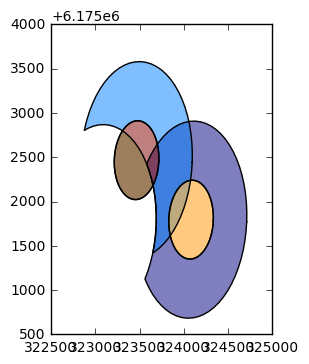

In [199]:
buff2 = update_buff(buff,1)
buff2.plot()

In [200]:
buff2

geometry id  \
type         office_id                                                         
foot         2          POLYGON ((324708.9411055354 6176770.773440831,...  1   
             3          POLYGON ((324093.4350822463 6177442.195657966,...  2   
foot_to_step 3          POLYGON ((323650.7056755868 6177182.944721881,...  2   
stepless     2          POLYGON ((324332.0519752682 6176785.962527644,...  1   
             3          POLYGON ((323716.6030875866 6177457.439125905,...  2   

                       priority  
type         office_id           
foot         2             None  
             3             None  
foot_to_step 3             None  
stepless     2             None  
             3             None

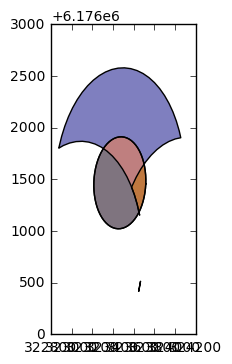

In [201]:
update_buff(buff2, 2).plot()

## Check Preparation

In [205]:
poi[poi.intersects(buff.unary_union)]

,geometry,score,pid,disability
0,POINT (323791.6878816557 6177125.693802821),400,2,blind
1,POINT (323740.0368038155 6177849.711619716),800,4,deaf
2,POINT (323106.2205034501 6177665.384873792),100,3,disabled
3,POINT (323563.2483434519 6176951.761391419),1500,5,disabled
4,POINT (323069.4962143562 6176761.647416742),1000,1,dusabled


# CHeck overal iteration

In [33]:
?iteration

In [ ]:
iteration(1, buff, poi, reg, COVERED, settings)